# TA Session 2

`Econometrics II with Michael Creel (IDEA, Spring 2024)`

`TA:` Conghan Zheng

`Description` 
1. Common mistakes in your PS1 solutions
2. PS2 tutorials:
    - Simulation: Pseudorandom-Number Generators and Grid Search
    - MLE and LR Test
   
`Last updated:`26 APR 2024

`Compiled with`: Julia 1.10.2

The Julia code in this document is also available in Matlab code (<code>TA2.m</code>).

***

## Common Mistakes in Your PS1 Solutions

### 1. The Syntax of <code>fmincon</code> Function

The syntax for the Matlab <code>fmincon</code> function is as follows 

<code>x = fmincon(fun,x0,A,b,Aeq,beq)</code>,

where $A$ and $b$ refer to the linear inequality constraint $A \cdot x \leq b$. If there are no inequalities, set $A = [\,]$ and $b = [\,]$:

<code> fmincon(fun,x0,[],[],Aeq,beq)</code>. Some of you missed the two empty brackets and got wrong results. 

### 2. Interpreting the F-test Results

Some of you made these kinds of interpretations: "the $p$-value is 0" (no, it's never 0 if there's at least some variation in your data), "for any significance level" (no, you can only say "commonly used levels", etc.), or draw the conclusion without specifying any $\alpha$, all of which are imprecise. Although you don't suffer any loss in your grade because of this.

When testing the null $H_0: R\beta = r$, to say whether $R\hat{\beta} - r$ is significantly different from zero, we define a decision rule that specifies a threshold with which we can compare the absolute values of $R\hat{\beta} - r$. 

Given a data set, we get only one realization of $R\hat{\beta} - r$, whether this realization is close to zero should be judged by its sampling distribution under the null, which depends on the sample size and some pre-selected significance level $\alpha$.

So you need to specify an $\alpha$ in your interpretation that defines "close to 0". 

In [7]:
## Package Dependencies
## - IJulia is also required for the use of Julia in Jupyter notebook
using Pkg
packages = [:Distributions, :Random, :DataFrames, :GLM, :Plots, :Optim, :Test, :Statistics, :NLopt]
for p in packages; (String(p) in keys(Pkg.project().dependencies)) || Pkg.add(String(p)); @eval using $p; end

## There is no need to specify a local path because we only use online data.

## PS2 tutorials

### 1. Simulation

#### Pseudorandom-number generators

The term “random-number generation” is an oxymoron. Strictly speaking, a deterministic machine like a computer can never produce any truly random results and we should instead refer to the generated numbers as pseudo-random numbers. Pseudorandom-number generators use deterministic devices to produce long chains of numbers that mimic the realizations from some target distribution. 

For normal random numbers, the target distribution is the standard normal distribution.

In [2]:
## Draws from Normal
normal_sample_tmp1 = round.(rand(Normal(), 6), digits=4) 
normal_sample_tmp2 = round.(rand(Normal(), 6), digits=4) 
println("Sample 1: \n $normal_sample_tmp1 \n")
println("Sample 2 from the same distribution: \n $normal_sample_tmp2")

Sample 1: 
 [0.1501, -0.363, 0.2999, 1.3872, 1.6939, -1.0457] 

Sample 2 from the same distribution: 
 [-1.208, 0.8722, -0.6133, -0.4134, -1.3052, -0.7901]


##### Seed

Working with computer-generated random samples creates problems for the reproducibility of the results. If you run the code above, you will get different samples. If we rerun the code, the sample will change again. We can solve this problem by making use of how the random numbers are actually generated which is, as already noted, not involving true randomness. Actually, we will always get the same sequence of numbers if we set the random number generator to some specific state (“seed”).

In [8]:
## Set the seed of the random number generator and take two samples: 
Random.seed!(54321)
normal_sample_tmp3 = round.(rand(Normal(), 6), digits=4) 
normal_sample_tmp4 = round.(rand(Normal(), 6), digits=4)
println("Sample 3: \n $normal_sample_tmp3 \n")
println("Sample 4: \n $normal_sample_tmp4 \n")

println("Seed reset to the same number ... \n")

## Reset the seed to the same value to get the same samples again: 
Random.seed!(54321)
normal_sample_tmp5 = round.(rand(Normal(), 6), digits=4) 
normal_sample_tmp6 = round.(rand(Normal(), 6), digits=4)
println("Sample 5: \n $normal_sample_tmp3 \n")
println("Sample 6: \n $normal_sample_tmp4")

Sample 3: 
 [-0.0218, -1.7564, 0.5612, 0.8019, -0.5606, 0.6231] 

Sample 4: 
 [0.7308, -0.0399, 0.5367, 0.3072, 0.2068, 0.4699] 

Seed reset to the same number ... 

Sample 5: 
 [-0.0218, -1.7564, 0.5612, 0.8019, -0.5606, 0.6231] 

Sample 6: 
 [0.7308, -0.0399, 0.5367, 0.3072, 0.2068, 0.4699]


#### Simulation Example: OLS with $\chi^2$ errors

In this section, we use simulation methods to investigate the finite-sample properties of the OLS estimator with random regressors and skewed errors.

If the errors are i.i.d., the fact that they are skewed has no effect on the large sample properties of the OLS estimator (recall Econometrics I). However, when the errors are skewed, we will need a larger sample size for the asymptotic distribution to better approximate the finite-sample distribution of the OLS estimator than when the errors are normal. 

Consider the following data generating process (DGP), 
\begin{align*}
    y = 1 + 2 x + \varepsilon, \quad \varepsilon \sim \chi^2(1) - 1, \quad x \sim \chi^2(1), \quad x \perp \varepsilon
\end{align*}

In this DGP, the error term $\varepsilon$ has a mean of zero, variance of 2, skewness of $\sqrt{8}$, kurtosis of 15. By contrast, a normal error has a skewness of 0 and a kurtosis of 3. 

Suppose we want to perform some simulations, where in each simulation we obtain parameter estimates, standard errors, $t$-values for the test of $H_0: \beta_x = 2$, and the outcome of a two-sided test of $H_0$ at level 0.05.

If the estimator is consistent, then any bias should disappear as the sample size goes to infinity. 

Also notice that because we impose looser restrictions on the DGP, $t$ statistics are not exactly $t$-distributed, and the extent to which they diverge from the reference distribution disappears as the sample size increases. Rather than focus on the distribution of the statistics, we instead focus on the size/power of tests (the probability of rejecting the null when it is true).

In [9]:
"""
Function: Function for finite-sample properties of OLS with Chi-Squared Errors
- Input: n = sample size
"""
function chi2ols(n)
    Random.seed!(37261)
    x = rand(Chisq(1), n)
    u = rand(Chisq(1)-1, n) ## demeaned χ² error
    y = 1 .+ 2*x + u
    k = 2

    b = cov(x, y) / var(x)
    #lmest = lm(@formula(y ~ x), DataFrame(x=x, y=y))
    #b = coef(lmest)[2]
    e = y - b*x
    se = sqrt((sum(e.^2)/(n-k))/(sum(x .* x)))

    t = b / se
    p = 2 * (1 - cdf(TDist(n-k), abs(t)))
    
    return b, se, t, p
end

## Example usage
n1 = 15
println("[b, se, t, p] from a random sample of size N = $n1: \n")
println(chi2ols(n1);)
println("\n")

n2 = 150
println("[b, se, t, p] from a random sample of size N = $n2: \n")
println(chi2ols(n2);)
println("\n")

n3 = 1500
println("[b, se, t, p] from a random sample of size N = $n3: \n")
println(chi2ols(n3);)

[b, se, t, p] from a random sample of size N = 15: 

(1.7743905770816895, 0.2664474715068859, 6.659438601712657, 1.5651234890556864e-5)


[b, se, t, p] from a random sample of size N = 150: 

(2.01674965387639, 0.0999674162452444, 20.174070008259612, 0.0)


[b, se, t, p] from a random sample of size N = 1500: 

(1.9808698703861023, 0.02665432085845616, 74.3170265303408, 0.0)


#### Grid Search

Since sample sizes are usually quite large and computational power is limited, a traditional approach to numerical optimization is to evaluate the objective function over a manually specified subset of the parameter space and simply do an exhaustive search.

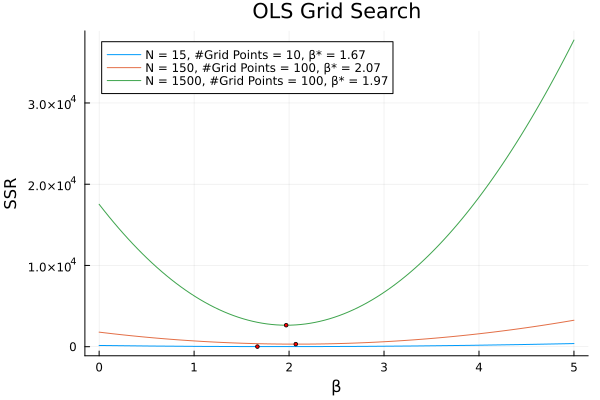

In [10]:
"""
Function: Grid Search for OLS with Chi-Squared Errors
- Inputs: n = sample size, G = number of grid points
"""
function chi2ols_grid(n,G)
    Random.seed!(37261)
    x = rand(Chisq(1), n)
    u = rand(Chisq(1)-1, n) ## demeaned χ² error
    y = 1 .+ 2*x + u
    k = 2

    betas = range(0, stop=5, length=G)  ## Set up the grid, a subset of the parameter space
    ssr = zeros(G)

    ## Loop over values on the grid and compute the objective function value
    for i in 1:G
        beta = betas[i]
        e = y .- 1 .- beta .* x
        ssr[i] = sum(e .^ 2)
    end

    ind = argmin(ssr)

    return betas, ssr, ind
end

## Example usage
n1, G1 = 15, 10
n2, G2 = 150, 100
n3, G3 = 1500, 100

betas1, ssr1, ind1 = chi2ols_grid(n1,G1)
betas2, ssr2, ind2 = chi2ols_grid(n2,G2)
betas3, ssr3, ind3 = chi2ols_grid(n3,G3)

plot(betas1, ssr1, label="N = $n1, #Grid Points = $G1, β* = $(round(betas1[ind1], digits=2))")
plot!(betas2, ssr2, label="N = $n2, #Grid Points = $G2, β* = $(round(betas2[ind2], digits=2))")
plot!(betas3, ssr3, label="N = $n3, #Grid Points = $G3, β* = $(round(betas3[ind3], digits=2))")
scatter!([betas1[ind1]], [ssr1[ind1]], color=:red, markersize=2, label = "")
scatter!([betas2[ind2]], [ssr2[ind2]], color=:red, markersize=2, label = "")
scatter!([betas2[ind3]], [ssr3[ind3]], color=:red, markersize=2, label = "")
xlabel!("β")
ylabel!("SSR")
title!("OLS Grid Search")

### 2. MLE and Likelihood-Ratio Test

In [14]:
"""
Function: generate the random sample [y x] with N, k, beta, and sigma
"""
function random_data(n, k, theta)

    b = theta[1:k]
    s = theta[k+1]

    x = [ones(n,1) rand(n,k-1)]
    e = s*randn(n)
    y = x*b + e

    z = [y x]
end

"""
Function: the log-likelihood for the classical linear model
          y = x*b+e, with e~N(0,s^2)
          theta = [b' s]
"""
function Normal_ll(theta, data)

    y = data[:,1]
    x = data[:,2:end]
    n, k = size(x)

    b = theta[1:k]
    s = theta[k+1]

    e = y - x*b

    logdensity = -log(sqrt(2*pi)) .- log(sqrt(s^2)) .- e.*e/(2*s^2)
    return logdensity
end

"""
Function: 

MATLAB fmincon function equivalent, adapted from https://github.com/mcreel/Econometrics/blob/main/src/Optimization/fmincon.jl

Usage: 

xopt, fopt, converged = fmincon(obj, startval, R, r, lb, ub; tol=tol, iterlim=0)

Minimizes the function obj subject to linear restraints Rb=r and box constraints defined by lower bounds lb and upper bounds ub, starting at startval. 

R and r can both be empty, by passing []
lb and/or ub can also be empty, by passing []

Package dependencies: Package NLopt.jl required
"""
function fmincon(obj, startval, R=[], r=[], lb=[], ub=[]; tol = 1e-10, iterlim=0)
    # the objective is an anonymous function
    function objective_function(x::Vector{Float64}, grad::Vector{Float64})
        obj_func_value = obj(x)[1,1]
        return(obj_func_value)
    end
    # impose the linear restrictions
    function constraint_function(x::Vector, grad::Vector, R, r)
        result = R*x .- r
        return result[1,1]
    end
    opt = Opt(:LN_COBYLA, size(startval,1))
    min_objective!(opt, objective_function)
    # impose lower and/or upper bounds
    if lb != [] lower_bounds!(opt, lb) end
    if ub != [] upper_bounds!(opt, ub) end
    # impose linear restrictions, by looping over the rows
    if R != []
        for i = 1:size(R,1)
            equality_constraint!(opt, (theta, g) -> constraint_function(theta, g, R[i:i,:], r[i]), tol)
        end
    end    
    xtol_rel!(opt, tol)
    ftol_rel!(opt, tol)
    maxeval!(opt, iterlim)
    (objvalue, xopt, flag) = NLopt.optimize(opt, startval)
    return xopt, objvalue, flag
end

Random.seed!(54321)

## Specification:
## y = β₀ + β₁*x₁ + β₂*x₂ + β₃*x₃ + u, u ~ N(0,σ²)

k = 4 # number of regressors including the constant term
theta = rand(k+1)
theta0 = ones(k+1)
R = [0 1 0 0 0; 0 0 1 1 0]
r = [1;1]
J = 2
tol = 1e-10

## Example Usage

## Samples
n1 = 50
data1 = random_data(n1, k, theta)
obj1 = θ -> - Statistics.mean(Normal_ll(θ, data1))

n2 = 500
data2 = random_data(n2, k, theta)
obj2 = θ -> - Statistics.mean(Normal_ll(θ, data2))

n3 = 5000
data3 = random_data(n3, k, theta)
obj3 = θ -> - Statistics.mean(Normal_ll(θ, data3))

## - Unconstrained MLE
result_U1 = Optim.optimize(obj1, theta0, LBFGS(), Optim.Options(x_tol = tol, g_tol = tol, f_tol = tol))
theta_U1 = Optim.minimizer(result_U1)
ll_U1 = - Optim.minimum(result_U1)

result_U2 = Optim.optimize(obj2, theta0, LBFGS(), Optim.Options(x_tol = tol, g_tol = tol, f_tol = tol))
theta_U2 = Optim.minimizer(result_U2)
ll_U2 = - Optim.minimum(result_U2)

result_U3 = Optim.optimize(obj3, theta0, LBFGS(), Optim.Options(x_tol = tol, g_tol = tol, f_tol = tol))
theta_U3 = Optim.minimizer(result_U3)
ll_U3 = - Optim.minimum(result_U3)

## - Constrained MLE
theta_C1, ll_C1 = fmincon(obj1, theta0, R, r)
ll_C1 = - ll_C1
theta_C2, ll_C2 = fmincon(obj2, theta0, R, r)
ll_C2 = - ll_C2
theta_C3, ll_C3 = fmincon(obj3, theta0, R, r)
ll_C3 = - ll_C3

## - Likelihood Ratio Tests
LR1 = 2*n1*(ll_U1 - ll_C1)
p_LR1 = 1.0-cdf(Chisq(J),LR1)

LR2 = 2*n2*(ll_U2 - ll_C2)
p_LR2 = 1.0-cdf(Chisq(J),LR2)

LR3 = 2*n3*(ll_U3 - ll_C3)
p_LR3 = 1.0-cdf(Chisq(J),LR3)

## Print the results
df = DataFrame()

df."Sample Size" = [n1, n2, n3]
df."True Parameters" = [round.(vec, digits=2) for vec in [theta, theta, theta]]
df."Unconstrained MLE" = [round.(vec, digits=2) for vec in [theta_U1, theta_U2, theta_U3]]
df."Log-likelihood (U)" = round.([ll_U1,ll_U2,ll_U3], digits=2)
df."Constrained MLE" = [round.(vec, digits=2) for vec in [theta_C1, theta_C2, theta_C3]]
df."Log-likelihood (C)" = round.([ll_C1,ll_C2,ll_C3], digits=2)
df."LR Stat." = round.([LR1, LR2, LR3], digits=2)
df."p-value (LR)" = round.([p_LR1, p_LR2, p_LR3], digits=2)

display(df)

Row,Sample Size,True Parameters,Unconstrained MLE,Log-likelihood (U),Constrained MLE,Log-likelihood (C),LR Stat.,p-value (LR)
,Int64,Array…,Array…,Float64,Array…,Float64,Float64,Float64
1,50,"[0.03, 0.73, 0.21, 0.69, 1.0]","[-0.69, 1.21, 0.98, 0.82, 0.82]",-1.22,"[-0.13, 1.0, 0.61, 0.39, 0.84]",-1.24,2.63,0.27
2,500,"[0.03, 0.73, 0.21, 0.69, 1.0]","[0.02, 0.56, 0.22, 0.81, 0.98]",-1.4,"[-0.18, 1.0, 0.21, 0.79, 0.99]",-1.41,8.4,0.01
3,5000,"[0.03, 0.73, 0.21, 0.69, 1.0]","[0.03, 0.76, 0.26, 0.66, 0.99]",-1.41,"[-0.13, 1.0, 0.3, 0.7, 1.0]",-1.42,26.66,0.0


### 3. Q & A on PS2

#### MLE of the Linear Regression Model with Normal Errors

\begin{align*}
    y = x \beta + \varepsilon, \, \varepsilon \vert x \sim \mathcal{N} (0,\sigma_{\varepsilon}^2)
\end{align*}

Some of you is using the following <code>Matlab</code> function, which gives us the pdf of $N(\mu_y,\sigma_y^2)$ evaluated at $y$, to calculate the normal density but misses the $\sigma$ estimates.

<code>f = normalpdf(y, mu(y), sigma(y))</code>

Here I explain why. First, we write the expression of $\mu_y$ and $\sigma_y$ in terms of data and parameters.
\begin{align*}
    \mu_y &= \mathbf{E}(y|x) = \mathbf{E}(x\beta + \varepsilon |x) = x \beta \\
    \sigma^2_y &= \mathbf{E} \left\{ \left[ y - \mathbf{E}(y|x) \right]' \left[ y - \mathbf{E}(y|x) \right] \middle\vert x \right\}  = \underbrace{\mathbf{E} \left[ \left( y - x\beta \right)' \left( y - x\beta \right) \middle\vert x \right]}_{\equiv \Delta} = \mathbf{E} \left( \varepsilon' \varepsilon \middle\vert x \right) = \sigma_{\varepsilon}^2 \cdot \mathbf{I}
\end{align*}

If you plug the square root of expression $\Delta$ directly into your normal density function, then there is no $\sigma_{\varepsilon}$ in your density expression. This means that, you are not estimating $\sigma_{\varepsilon}$, and instead of the true maximization problem, where you are finding a $\sigma$ over the parameter space to minimize the problem
\begin{align*}
    (\beta, \sigma_{\varepsilon})_{\text{MLE}} = \argmax_{(\beta, \sigma)} \, \frac{1}{N} \sum_{i = 1}^N \ln f(y_i \vert x_i, \beta, \sigma_{\varepsilon}),
\end{align*}
you write $\sigma$ as a function of data and $\beta$, and just take the sample residual ($e'e/N$) as its estimates. Which means that in your case, $\sigma$ is not ML-estimated. But you will still get right estimates for $\beta$ just because this is a special linear case, if the problem is more complicated, your $\beta$ would be also wrong.

Recall from our TA session: 
\begin{align*}
      f (y_i \vert x_i, \theta) 
      & = \mathbb{P} (\mathbf{y}_i = y_i \vert x_i) 
      = \mathbb{P} (x_i'\beta + \varepsilon_i = y_i) = \mathbb{P} (\varepsilon_i = y_i - x_i'\beta) \\
      & = \mathbb{P} \left(\frac{\varepsilon_i}{\sigma} = \frac{y_i - x_i'\beta}{\sigma} \right) = \phi\left(\frac{y_i - x_i'\beta}{\sigma}\right)
\end{align*}

If you don't introduce $\varepsilon$ into your target density, then instead of estimating $\phi\left(\frac{y_i - x_i'\beta}{\sigma}\right)$, you are estimating $\phi\left(\frac{y_i - x_i'\beta}{\sqrt{(y_i - x_i'\beta)'(y_i - x_i'\beta)}}\right) = \phi\left(\frac{y_i - x_i'\beta}{\sigma} \cdot \frac{\sigma}{\sqrt{(y_i - x_i'\beta)'(y_i - x_i'\beta)}}\right)$. Scaling of a mean-zero variable doesn't change its mean, so this error won't affect the mean estimates $\beta$. But it would affect the variance estimates $\sigma$. Since the MLE for $\sigma$ is the most efficient estimator under normal assumption, it for certain outperforms the wrong estimator $\frac{1}{N} \sum_i \sqrt{(y_i - x_i'\beta)'(y_i - x_i'\beta)}$ which is just a sample average of the residuals.

For the correct usage of either the built-in <code>normalpdf</code> function or a manual function in <code>Matlab</code> for doing the MLE, please check the updated <code>TA2.m</code> script. You can use that code in your solution. 